In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [3]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
model_zip = FetchModel("zip").compile()

In [7]:
data_zip = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi" : phi,
    "distances" : distances,
    "nmonths" : 7,
    "month" : months_obs
}

fit_zip = model_zip.sample(data=data_zip, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_zip = az.from_cmdstanpy(fit_zip)

01:20:09 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:26:11 - cmdstanpy - INFO - CmdStan done processing.


01:26:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/

In [19]:
post_pred = PostPred(posterior_180_zip, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

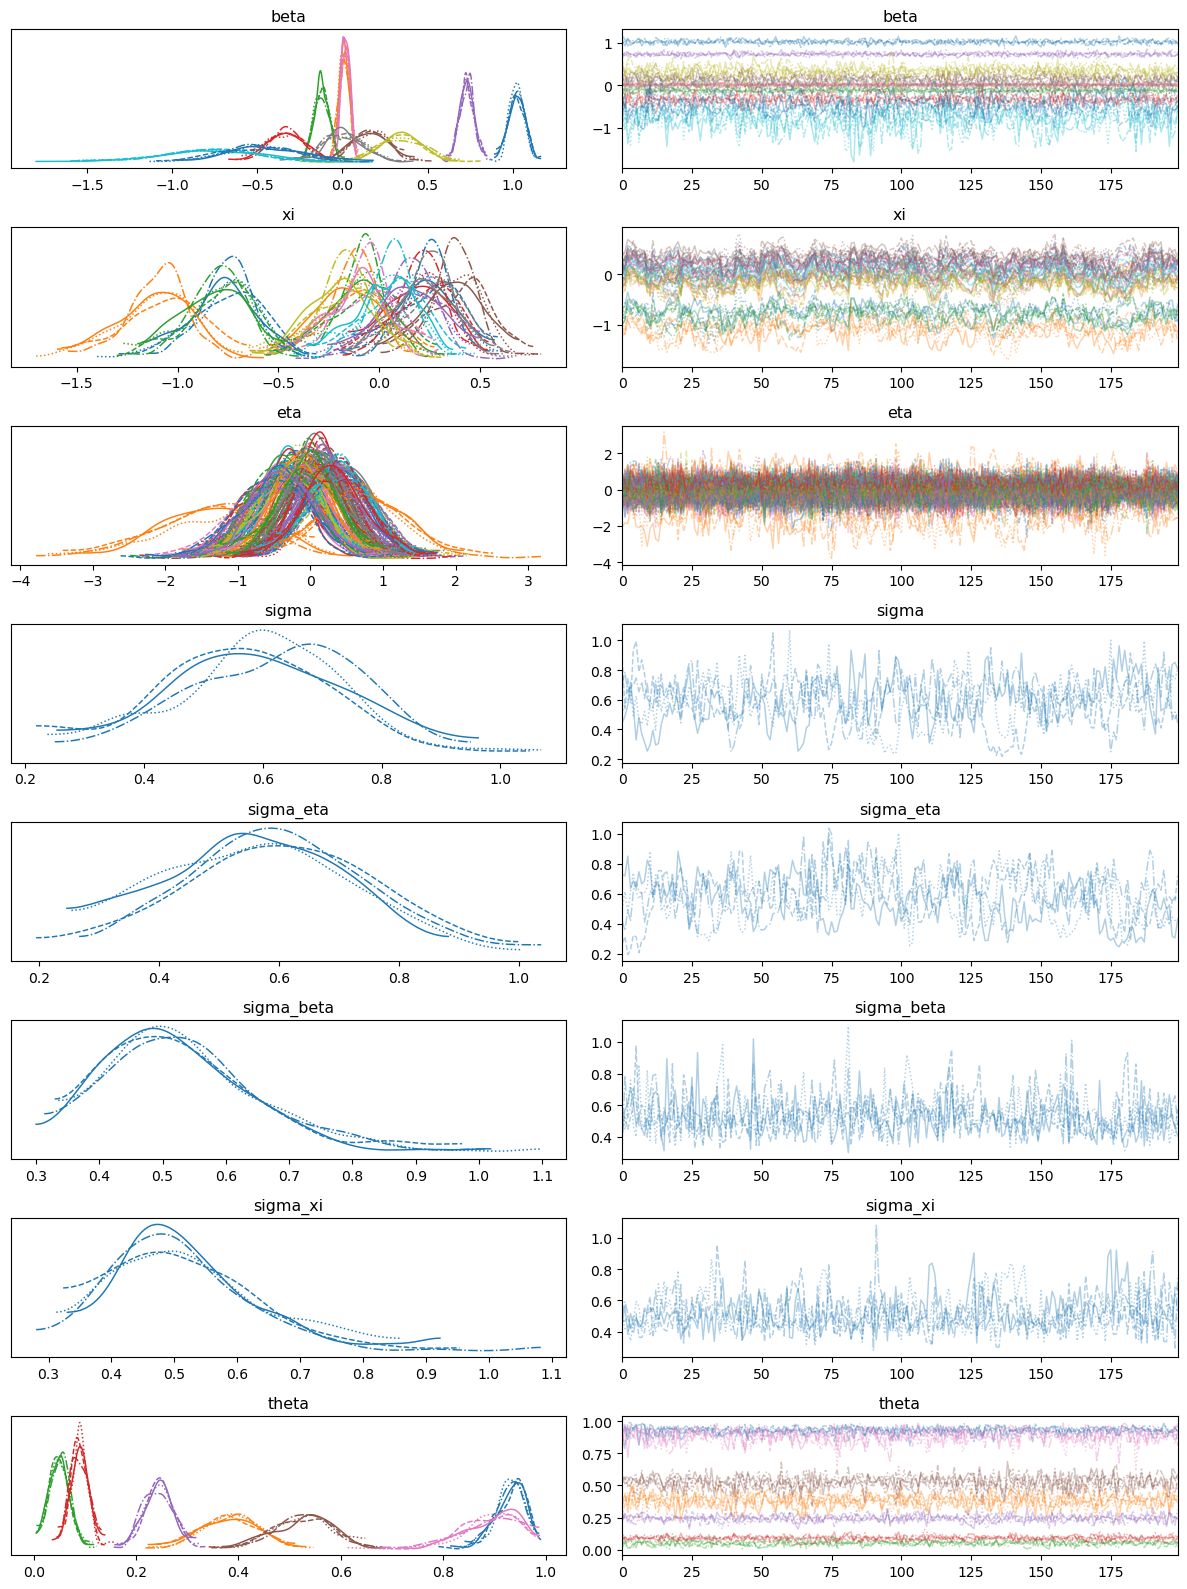

In [20]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [21]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3713.45    78.51
p_waic       99.79        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3714.51    78.56
p_loo      100.85        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3801   99.8%
 (0.5, 0.7]   (ok)          6    0.2%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [22]:
y_pred, metrics = post_pred.predict(error_metrics=True)

In [30]:
alpha = 0.05
theta_med = post_pred.posterior_med.theta.values
alpha_adj = (1+alpha+theta_med-alpha*theta_med)/2
alpha_adj

array([0.96864288, 0.70719433, 0.54862287, 0.56712241, 0.64109546,
       0.77638544, 0.95338326])

In [32]:
alpha_adj[months_obs[0]-1]

0.968642875

In [62]:
alpha = 0.05
theta_med = post_pred.posterior_med.theta.values
alpha_adj = (1+alpha+theta_med-alpha*theta_med)/2
quantiles_per_month = [post_pred.posterior.y_pred.quantile([alpha_adj[i]/2, 1-alpha_adj[i]/2], dim=['chain', 'draw']).values for i in range(0, len(alpha_adj))]
y_CI = [quantiles_per_month[months_obs[i]-1][:, i] for i in range(0, len(months_obs))]
y_star_up = [y_CI[i][1] for i in range(0, len(y_CI))]
y_star_low = [y_CI[i][0] for i in range(0, len(y_CI))]
y_star_up = pd.Series(y_star_up)
y_star_low = pd.Series(y_star_low)

In [70]:
outliers = np.where(((Y_obs['Count_180'] > y_star_up) | (Y_obs['Count_180'] < y_star_low)) & Y_obs['Count_180'] != 0)[0]
percentage_inside = 1 - len(outliers)/len(Y_obs)

In [71]:
y_obs, residuals, mse, mae, mad = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2    9   12   17   25   26   36   38   46   55   72   74   78   79
   84   85   89   94   99  100  104  112  118  144  150  155  160  161
  166  167  173  174  176  187  193  231  233  250  278  279  280  284
  285  287  293  330  331  337  339  340  344  345  346  347  351  352
  364  365  366  371  372  376  378  383  384  385  401  402  403  407
  409  415  426  441  456  474  475  481  483  507  510  529  558  574
  579  587  593  595  596  599  601  602  607  609  622  630  635  642
  643  644  650  651  656  657  658  663  669  670  675  676  677  678
  683  697  698  699  722  728  729  735  790  791  792  796  797  798
  800  801  809  835  850  851  852  859  862  867  869  872  873  914
  998 1002 1009 1014 1019 1020 1029 1035 1036 1042 1043 1050 1077 1078
 1084 1085 1087 1092 1093 1094 1114 1118 1119 1122 1126 1128 1133 1134
 1135 1136 1141 1143 1149 1150 1154 1156 1157 1161 1168 1169 1177 1180
 1181 1182 1183 1191 1202 1204 1208 1209 1210 1212 1215 1216 1218 1

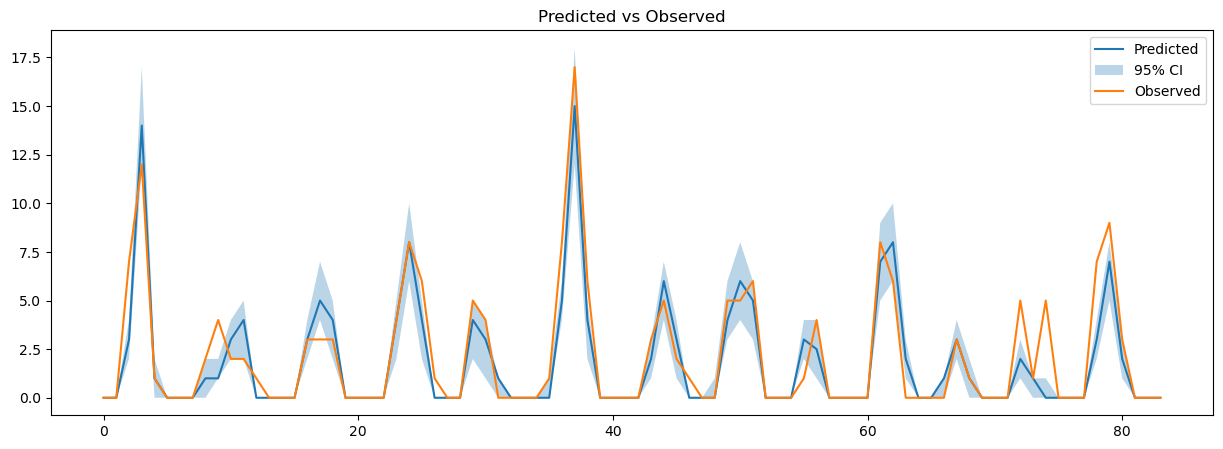

In [73]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label='95% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()